In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve
from scipy import ndimage
from skimage import measure
import cv2

In [2]:
img = plt.imread('masked_image.png')

1. turn image grayscale

In [3]:

gray_matrix = np.array([[0.2989, 0.5870, 0.1140],
                        [0.2989, 0.5870, 0.1140],
                        [0.2989, 0.5870, 0.1140],])

def apply_filter(img, filter):
    img = img[:,:,:3]
    img = np.dot(img, filter.T)
    img = np.clip(img, 0, 1)
    return img

2. apply gaussian blur.

In [4]:
def gaussian_kernel(kernel_size, sigma=1):
    size = int(kernel_size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    return g

In [5]:
def sobel_filters(img):
    ''' input: a gray scale image
       output: the gray scale edge detection image, and direction matrix theta'''
    Kx = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
    Ky = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]], np.float32)

    Ix = convolve(img, Kx)
    Iy = convolve(img, Ky)

    G = np.hypot(Ix, Iy)
    G = G / G.max() * 255
    theta = np.arctan2(Iy, Ix)

    return (G, theta)

In [6]:
def edge_thinning(img, D):
    '''input: Intensity Matrix img, and direction matrix D'''
    M, N = img.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = D * 180. / np.pi   # convert direction matrix from radians to degrees
    angle[angle < 0] += 180 # map all angles from 0 to 180

    for i in range(1,M-1):
        for j in range(1,N-1):
            try:
                q = 255
                r = 255

               #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = img[i+1, j]
                    r = img[i-1, j]
                #angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]
                #angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = img[i, j+1]
                    r = img[i, j-1]
                #angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]

                if (img[i,j] >= q) and (img[i,j] >= r):
                    Z[i,j] = img[i,j]
                else:
                    Z[i,j] = 0

            except IndexError as e:
                pass

    return Z


In [7]:
def dbl_threshold(img, lowThresholdRatio=0.05, highThresholdRatio=0.09):

    highThreshold = img.max() * highThresholdRatio
    lowThreshold = highThreshold * lowThresholdRatio

    M, N = img.shape
    res = np.zeros((M,N), dtype=np.int32)

    weak = np.int32(25)
    strong = np.int32(255)

    strong_i, strong_j = np.where(img >= highThreshold)
    zeros_i, zeros_j = np.where(img < lowThreshold)

    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))

    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak

    return (res, weak, strong)


In [8]:
def hysteresis(img, weak, strong=255):
    M, N = img.shape  
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i,j] == weak):
                try:
                    if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                        or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                        or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                        img[i, j] = strong
                    else:
                        img[i, j] = 0
                except IndexError as e:
                    pass
    return img


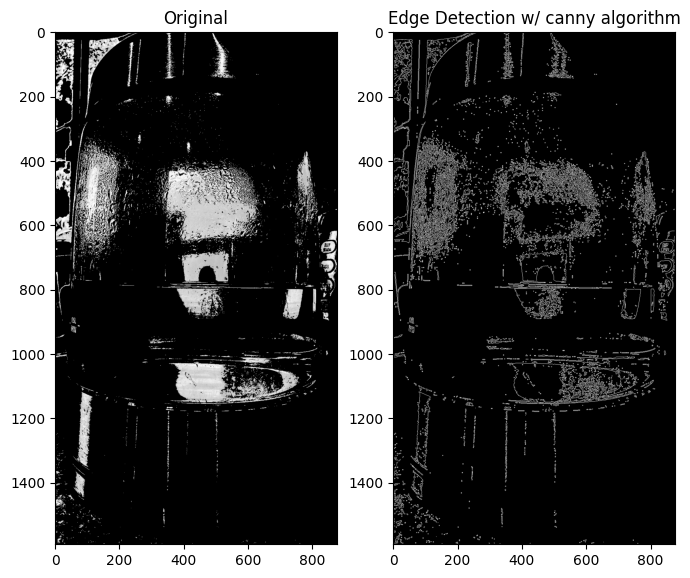

In [9]:
# load and covert image to gray scale
gray_img = np.dot(img[...,:3], [0.2989, 0.5870, 0.1140])

# apply gaussian blur
# disabled this because i already did gaussian in preprocessing
# img_gb = convolve(gray_img, gaussian_kernel(7))

# apply Sobel filters
img_sobel, theta = sobel_filters(gray_img)
# idea: add animation how changing the sobel filter changes the image
img_sobel[img_sobel < 0.2 * img_sobel.max()] = 0

# apply Edge thinning
img_nms = edge_thinning(img_sobel,theta)

# apply Double Threshold
img_dt, weak, strong = dbl_threshold(img_nms)

# edge tracking by hysteresis
img_h = hysteresis(img_dt, weak)
# remove weak edges
img_h[img_h == weak] = 0

# display images
fig = plt.figure(figsize=(8,8))
fig.add_subplot(1,2,1)
plt.imshow(img, cmap="gray")
plt.title("Original")
fig.add_subplot(1,2,2)
plt.imshow(img_h, cmap="gray")
plt.title("Edge Detection w/ canny algorithm")
plt.imsave('canny_edge.png', img_h, cmap='gray')


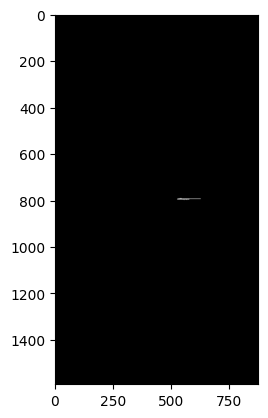

In [10]:
from skimage import measure

# Find contours
contours = measure.find_contours(img_h, 0.5)

# Keep only the longest contour (assumes cube is the largest object)
longest_contour = max(contours, key=lambda x: len(x))

# Create a clean outline
outline = np.zeros_like(img_h)
for coord in longest_contour:
    outline[int(coord[0]), int(coord[1])] = 1

plt.imshow(outline, cmap='gray')